# Florida Panthers - Extended Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 15, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard features used by the StellarAlgo retention model, plus two more features (cancel_records and resale_records).

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [8]:
import getpass
import pyodbc
import pandas as pd
import warnings

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [14]:
lkupclientid = 93 # Florida Panthers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNHLPanthers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(15842, 55)

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [17]:
# choose the features for the stellar base retention model + forward and resale records
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "forward_records",
    "isNextYear_Buyer",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "resale_records",
    "source_tenure",
    "totalSpent",
    "year"
]

# select 90% of the data for training
df_train = df.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df.drop(df_train.index).reset_index(drop=True)

# choose features for each train dataset
df_train = df_train[features]

# choose features for each train dataset
df_eval = df_eval[features]

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (12674, 15)
Unseen Data For Predictions: (3168, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [18]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "forward_records",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "resale_records",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's add one extra model not included in the default pycaret algorithms (ngboost), then we can execute each model and see the performance metrics:

In [19]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.7665,0.8435,0.7966,0.7537,0.7745,0.5329,0.5339,0.0570
7,Random Forest Classifier,0.7588,0.8304,0.7852,0.7481,0.7661,0.5173,0.5182,0.2480
9,Extreme Gradient Boosting,0.7581,0.8369,0.7785,0.7505,0.7641,0.5160,0.5166,0.7430
2,Gradient Boosting Classifier,0.7471,0.8234,0.7754,0.7364,0.7551,0.4940,0.4951,0.1880
3,Extra Trees Classifier,0.7358,0.8088,0.7583,0.7282,0.7427,0.4714,0.4721,0.2410
0,Ada Boost Classifier,0.7146,0.7883,0.7507,0.7027,0.7257,0.4289,0.4302,0.3910
8,NGBClassifier,0.7057,0.7881,0.7546,0.6899,0.7206,0.4110,0.4133,3.3650
1,Decision Tree Classifier,0.6802,0.6802,0.6758,0.6846,0.6799,0.3605,0.3608,0.0250
4,K Neighbors Classifier,0.6242,0.6642,0.6376,0.6237,0.6305,0.2483,0.2485,0.0360
6,Logistic Regression,0.5864,0.6438,0.7481,0.5734,0.6462,0.1708,0.1789,0.0190


### The top model is performing well, so let's compare it against our unseen evaluation dataset:

In [20]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7623,0.8452,0.7906,0.7509,0.7703,0.5244,0.5252
1,0.7643,0.8340,0.7984,0.7500,0.7735,0.5283,0.5295
2,0.7633,0.8382,0.7725,0.7606,0.7665,0.5266,0.5266
3,0.7554,0.8349,0.7765,0.7472,0.7615,0.5107,0.5111
4,0.7939,0.8741,0.8255,0.7782,0.8011,0.5876,0.5887
5,0.7781,0.8428,0.8020,0.7674,0.7843,0.5561,0.5567
6,0.7702,0.8421,0.8098,0.7523,0.7800,0.5402,0.5418
7,0.7436,0.8268,0.7961,0.7224,0.7575,0.4869,0.4894
8,0.7732,0.8524,0.8039,0.7593,0.7810,0.5462,0.5471
9,0.7611,0.8449,0.7902,0.7491,0.7691,0.5220,0.5228


### Let's plot the features to see what attributes were the most important to an accurate prediction

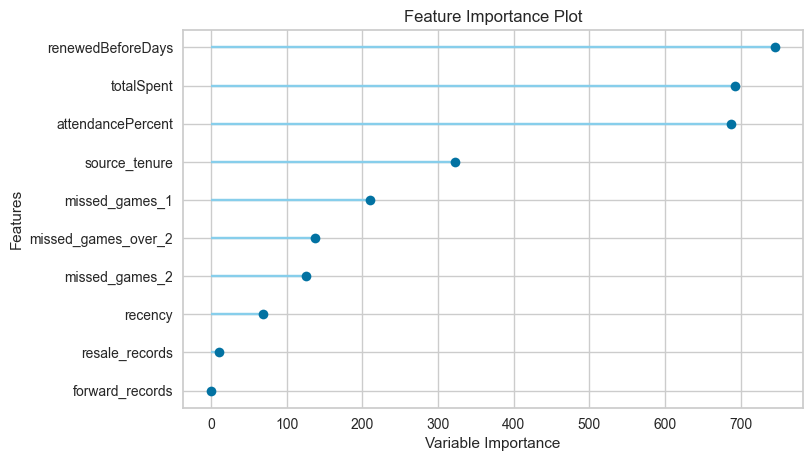

In [21]:
plot_model(best_model, plot='feature')

### Let's also plot a confusion matrix to understand the spread of our predictions

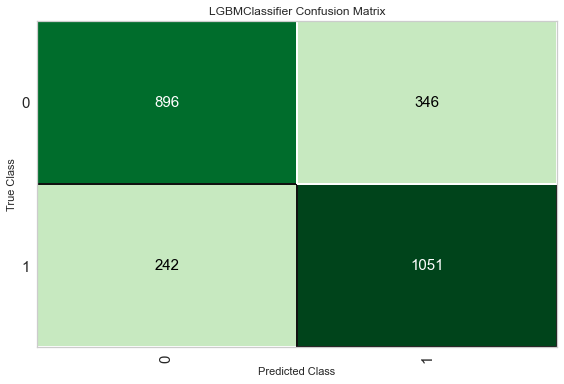

In [23]:
plot_model(best_model, plot='confusion_matrix')

## Observations

* There was a slight lift in accuracy by adding these two features (0.7635 to 0.7665).
* The resale_records and forward_records are the last two features on the feature importance matrix.
* Compared to the standard StellarAlgo retention features, the extended features predicted more overall buyers.

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?